# Using Images from HEASARC

In this notebook, we show how to search for and retrieve images from the HEASARC's holdings.

* [1. Finding](#finding) HEASARC SIA resources from the NAVO directory with TAP
* [2. Using](#sia) SIA to retrieve an image from SkyView


In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
import astropy
from IPython.display import Image as ipImage, display

## NAVO utilities
from navo_utils.image import Image, ImageColumn
from navo_utils.registry import Registry

## For handling ordinary astropy Tables
from astropy.table import Table

## For reading FITS files
import astropy.io.fits as apfits

## For pretty displays
import aplpy

## There are a number of relatively unimportant warnings that 
## show up, so for now, suppress them:
import warnings
warnings.filterwarnings("ignore")

/Users/tjaffe/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<a id="finding"></a>

# 1.  Finding HEASARC SIA resources from the NAVO directory with TAP

The __[HEASARC VO](https://heasarc.gsfc.nasa.gov/docs/archive/vo/instructions.html#_accessing)__ page describes how to access SkyView images with the __[Simple Image Access](http://www.ivoa.net/documents/SIA/)__ (SIA) protocol. But first, how do you know what sorts of images are available?

First, we can find out what SIA resources are available through SkyView. These are listed in a registry at STScI which we can access through the __[Table Access Protocol](http://www.ivoa.net/documents/TAP/)__ (TAP). The TAP protocol is described in detail in its own notebook.  Here, we submit an HTTP request to a given TAP service URL formed in a particular language (ADQL in this case) to specify what we wish to search for, in this case the HEASARC SIA resources.

(The properties we want, the short name, the description, and the URL, are each in different parts of the registry.  See the __[RegTAP](http://www.ivoa.net/documents/RegTAP/)__ documentation.)  

In [2]:
cat_table=Registry.query(service_type='image',source='heasarc',waveband='uv')
cat_table

<Table masked=True length=8>
                 waveband                 short_name ...    service_type  
                  str41                      str9    ...       str17      
----------------------------------------- ---------- ... -----------------
                                       uv       WFCF ... simpleimageaccess
                                       uv      GALEX ... simpleimageaccess
                               uv#optical  SWIFTUVOT ... simpleimageaccess
                                       uv       EUVE ... simpleimageaccess
                                       uv   GalexFar ... simpleimageaccess
                                       uv  GalexNear ... simpleimageaccess
radio#infrared#optical#uv#x-ray#gamma-ray    SkyView ... simpleimageaccess
                                       uv      WFCF1 ... simpleimageaccess

We can then specify the service we want by using the "access_url" entry in the row corresponding to the service we want.  The above is printing a subset of the rows, and below we'll use the row numbers that you can figure out from that. 

<a id="sia"></a>

# 2. Using SIA to retrieve an image from SkyView:

Now we pick one of these catalogs, the Swift UVOT from *SkyView* (note not the Xamin service;  see below), and look for images of our favorite source.  See __[the SIA definition](http://www.ivoa.net/documents/WD/SIA/sia-20040524.html)__ for usage.  In short, you specify the central position, POS, the angular SIZE, and the NAXIS, i.e., the number of bins.  (SkyView will bin/interpolate as needed from the archive data.)  

In [3]:
pos='202.469575,47.195258'
#import pdb; pdb.set_trace()
uvot_table=Image.query(service=cat_table[2],coords=pos,radius=0.2)
uvot_table[0]

Survey,Ra,Dec,Dim,Size,Scale,Format,PixFlags,URL,LogicalName
str16,float64,float64,int32,object,object,str10,str1,str272,str1
swiftuvotvint,202.469575,47.1952583,2,[300 300],[-0.0013333333333333335 0.0013333333333333335],image/fits,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.469575%2C47.1952583&survey=swiftuvotvint&pixels=300%2C300&sampler=LI&size=0.4000000000000001%2C0.4000000000000001&projection=Tan&coordinates=J2000.0&requestID=skv1527684934149&return=FITS,1
swiftuvotvint,202.469575,47.1952583,2,[300 300],[-0.0013333333333333335 0.0013333333333333335],image/jpeg,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.469575%2C47.1952583&survey=swiftuvotvint&pixels=300%2C300&sampler=LI&size=0.4000000000000001%2C0.4000000000000001&projection=Tan&coordinates=J2000.0&requestID=skv1527684934149&nofits=1&quicklook=jpeg&return=jpeg,1
swiftuvotbint,202.469575,47.1952583,2,[300 300],[-0.0013333333333333335 0.0013333333333333335],image/fits,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.469575%2C47.1952583&survey=swiftuvotbint&pixels=300%2C300&sampler=LI&size=0.4000000000000001%2C0.4000000000000001&projection=Tan&coordinates=J2000.0&requestID=skv1527684935081&return=FITS,2
swiftuvotbint,202.469575,47.1952583,2,[300 300],[-0.0013333333333333335 0.0013333333333333335],image/jpeg,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.469575%2C47.1952583&survey=swiftuvotbint&pixels=300%2C300&sampler=LI&size=0.4000000000000001%2C0.4000000000000001&projection=Tan&coordinates=J2000.0&requestID=skv1527684935081&nofits=1&quicklook=jpeg&return=jpeg,2
swiftuvotuint,202.469575,47.1952583,2,[300 300],[-0.0013333333333333335 0.0013333333333333335],image/fits,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.469575%2C47.1952583&survey=swiftuvotuint&pixels=300%2C300&sampler=LI&size=0.4000000000000001%2C0.4000000000000001&projection=Tan&coordinates=J2000.0&requestID=skv1527684937371&return=FITS,3
swiftuvotuint,202.469575,47.1952583,2,[300 300],[-0.0013333333333333335 0.0013333333333333335],image/jpeg,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.469575%2C47.1952583&survey=swiftuvotuint&pixels=300%2C300&sampler=LI&size=0.4000000000000001%2C0.4000000000000001&projection=Tan&coordinates=J2000.0&requestID=skv1527684937371&nofits=1&quicklook=jpeg&return=jpeg,3
swiftuvotuvw1int,202.469575,47.1952583,2,[300 300],[-0.0013333333333333335 0.0013333333333333335],image/fits,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.469575%2C47.1952583&survey=swiftuvotuvw1int&pixels=300%2C300&sampler=LI&size=0.4000000000000001%2C0.4000000000000001&projection=Tan&coordinates=J2000.0&requestID=skv1527684937886&return=FITS,4
swiftuvotuvw1int,202.469575,47.1952583,2,[300 300],[-0.0013333333333333335 0.0013333333333333335],image/jpeg,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.469575%2C47.1952583&survey=swiftuvotuvw1int&pixels=300%2C300&sampler=LI&size=0.4000000000000001%2C0.4000000000000001&projection=Tan&coordinates=J2000.0&requestID=skv1527684937886&nofits=1&quicklook=jpeg&return=jpeg,4
swiftuvotuvw2int,202.469575,47.1952583,2,[300 300],[-0.0013333333333333335 0.0013333333333333335],image/fits,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.469575%2C47.1952583&survey=swiftuvotuvw2int&pixels=300%2C300&sampler=LI&size=0.4000000000000001%2C0.4000000000000001&projection=Tan&coordinates=J2000.0&requestID=skv1527684938459&return=FITS,5


Extract the fields you're interested in, e.g., the URLs of the images made by skyview.  Note that specifying as we did SwiftUVOT, we get a number of different images, e.g., UVOT U, V, B, W1, W2, etc.  For each survey, there are two URLs, first the FITS IMAGE and second the JPEG:

In [4]:
rowf=6 # You see above that even-numbered rows are the JPEGs, the next the corresponding FITS
rowj=rowf+1
###  Inside the table is a numpy record array that you can access like this, for example:
###  (for the 0th object result, the 7th row, the 8th column)
#print(table.array[0][7][8])
#  Or like this
print(uvot_table[0][rowf][ImageColumn.ACCESS_URL])
### To download the FITS image itself:
print(uvot_table[0][rowj][ImageColumn.ACCESS_URL])

https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.469575%2C47.1952583&survey=swiftuvotuvw1int&pixels=300%2C300&sampler=LI&size=0.4000000000000001%2C0.4000000000000001&projection=Tan&coordinates=J2000.0&requestID=skv1527684937886&return=FITS
https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.469575%2C47.1952583&survey=swiftuvotuvw1int&pixels=300%2C300&sampler=LI&size=0.4000000000000001%2C0.4000000000000001&projection=Tan&coordinates=J2000.0&requestID=skv1527684937886&nofits=1&quicklook=jpeg&return=jpeg


### Resulting image
You can display it in python by
(give it ~10 seconds to appear)


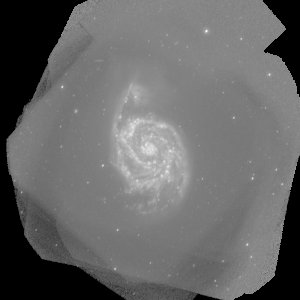

In [5]:
##  Note that there are bugs with some of these datasets, 
##  since they are new in SkyView.  Selecting the UVW1-band image.
##  (The decode is needed in Python 3.5 because it comes back a byte type.)
##  Handing pyImage(url="http....") to display doesn't always work for reasons unknown.  Download it first.
##  And because urllib is hard to make Python 2/3 compatible, just use requests:
import requests
r=requests.get(uvot_table[0][rowj][ImageColumn.ACCESS_URL], stream=True)
with open('my_image.jpeg','wb') as f:
    f.write(r.content)
display(ipImage("my_image.jpeg"))

Or download the FITS image and display it with:

(This often errors off with a time out message.  Just try it again, possibly a couple of times.)

In [6]:
## Download the FITS image?
r=requests.get(uvot_table[0][rowf][ImageColumn.ACCESS_URL], stream=True)
with open('my_image.fits','wb') as f:
    f.write(r.content)

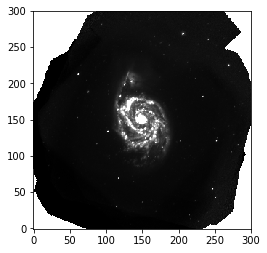

In [7]:
hdu_list=apfits.open('my_image.fits')
plt.imshow(hdu_list[0].data, cmap='gray', origin='lower',vmax=0.02)

### Now with aplpy

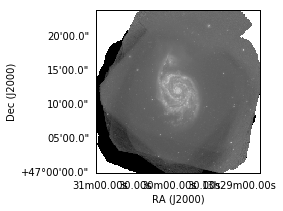

In [8]:
gc = aplpy.FITSFigure(hdu_list,figsize=(3, 3))
gc.show_grayscale(stretch='log', vmax=1.,vmin=0.00001)

### A related example with multiple VO interfaces
A very similar example uses the SkyView SIA protocol to retrieve an image from a different survey, SDSS, which is not held on the HEASARC SkyView server but at MAST.  In this case, the user is unaware of where the data come from, which is the point.  But under the hood, SkyView is using SIA to get the data from MAST.  

(Again, it will take a few seconds for the image to appear.)

In [9]:
cat_table=Registry.query(service_type='image',source='heasarc',keyword='sdss',waveband='optical')
cat_table

waveband,short_name,ivoid,res_description,access_url,reference_url,publisher,service_type
str7,str7,str34,str392,str67,str29,str17,str17
optical,SDSS,ivo://nasa.heasarc/skyview/sdss,The Sloan Digital Sky Survey is the deepest large scale survey of the sky currently available. SkyView dynamically queries the SDSS archive (currently release DR9) to retrieve information and resample it into the user requested frame. Further information on the SDSS and many additional services are available at the &amp;lt;a href=http://www.sdss.org&amp;gt; SDSS Web site&amp;lt;/a&amp;gt;.,https://skyview.gsfc.nasa.gov/cgi-bin/vo/sia.pl?survey=sdss&amp;,https://skyview.gsfc.nasa.gov,NASA/GSFC HEASARC,simpleimageaccess
optical,SDSSDR7,ivo://nasa.heasarc/skyview/sdssdr7,The Sloan Digital Sky Survey is the deepest large scale survey of the sky currently available. SkyView dynamically queries the SDSS archive to retrieve information and resample it into the user requested frame. Further information on the SDSS and many additional services are available at the &amp;lt;a href=http://www.sdss.org&amp;gt; SDSS Web site&amp;lt;/a&amp;gt;.,https://skyview.gsfc.nasa.gov/cgi-bin/vo/sia.pl?survey=sdssdr7&amp;,https://skyview.gsfc.nasa.gov,NASA/GSFC HEASARC,simpleimageaccess


In [10]:
sdss_table=Image.query(cat_table[0],coords=pos,radius=0.2)
sdss_table[0]
r=requests.get(sdss_table[0][0][ImageColumn.ACCESS_URL], stream=True)
with open('my_image2.fits','wb') as f:
    f.write(r.content)

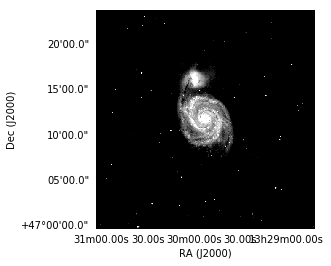

In [11]:
hdu_list=apfits.open('my_image2.fits')
gc = aplpy.FITSFigure(hdu_list,figsize=(4,4))
gc.show_grayscale(stretch='log', vmin=0.1,vmax=1.)


# 3. Retrieving a 'raw' image from Xamin
The SkyView service is a flexible and powerful way to view any sized region of the sky and to compare among different telescopes.  The results, however, are smoothed, interpolated and mosaic'd in a way that makes the scientific interpretation more complicated.  If you wish to retrieve the original observation data, these are listed in HEASARC's __[Xamin](https://heasarc.gsfc.nasa.gov/xamin/)__ service, which also provides an SIA interface.

Above, we used the TAP to query the registry of SIA services and selected a Swift UVOT image from SkyView.  But we could instead use the Xamin query for the original observation images.

In [12]:
cat_table=Registry.query(service_type='image',source='heasarc',keyword='swift')
cat_table[2]

waveband,short_name,ivoid,res_description,access_url,reference_url,publisher,service_type
str10,str10,str37,str7035,str70,str58,str17,str17
gamma-ray,SwiftUVOT,ivo://nasa.heasarc/swiftuvlog,"The UVOT runs only one type of configuration filter/mode/window in a given time interval. This database table, therefore, contains for a given time interval a single record that describes one configuration.",https://heasarc.gsfc.nasa.gov/xamin/vo/sia?table=swiftuvlog&amp;,https://heasarc.gsfc.nasa.gov/W3Browse/all/swiftuvlog.html,NASA/GSFC HEASARC,simpleimageaccess


In [13]:
uvot_raw_table=Image.query(cat_table[2],coords=pos,radius=0.02)
uvot_raw_table[0]

target_id,obsid,ra,dec,start_time,exposure,counts,window_size,binning,filter,operation_mode,pointing_mode,SIA_title,SIA_scale,SIA_naxis,SIA_naxes,SIA_format,SIA_reference,SIA_ra,SIA_dec,SIA_instrument
,,deg,deg,mjd,s,ct,,,,,,,,,,,,,,
str5,str11,float64,float64,float64,float64,float64,str11,int32,str6,str11,str8,str31,object,object,int32,str10,str152,float64,float64,str10
32017,00032017066,202.47760,47.15665,55745.4942,9.764,141554,1407 x 1380,2,U,Image,POINTING,00032017066_9.76412000000000013,[--],[1407 1380],2,image/fits,https://heasarc.gsfc.nasa.gov/xamin/vo/extract?file=/FTP/swift/data/obs/2011_07/00032017066/uvot/image/sw00032017066uuu_sk.img.gz&extension=uu331386704I,202.4776,47.15665,Swift UVOT
32017,00032017066,202.47760,47.15665,55745.4945,99.775,376134,433 x 422,2,U,Image,POINTING,00032017066_99.7754999999999939,[--],[433 422],2,image/fits,https://heasarc.gsfc.nasa.gov/xamin/vo/extract?file=/FTP/swift/data/obs/2011_07/00032017066/uvot/image/sw00032017066uuu_sk.img.gz&extension=uu331386729I,202.4776,47.15665,Swift UVOT
32017,00032017066,202.47760,47.15665,55745.4962,9.775,307993,1407 x 1381,2,B,Image,POINTING,00032017066_9.77515999999999963,[--],[1407 1381],2,image/fits,https://heasarc.gsfc.nasa.gov/xamin/vo/extract?file=/FTP/swift/data/obs/2011_07/00032017066/uvot/image/sw00032017066ubb_sk.img.gz&extension=bb331386874I,202.4776,47.15665,Swift UVOT
32017,00032017066,202.47760,47.15665,55745.4965,99.775,761115,433 x 422,2,B,Image,POINTING,00032017066_99.7754800000000017,[--],[433 422],2,image/fits,https://heasarc.gsfc.nasa.gov/xamin/vo/extract?file=/FTP/swift/data/obs/2011_07/00032017066/uvot/image/sw00032017066ubb_sk.img.gz&extension=bb331386899I,202.4776,47.15665,Swift UVOT
32017,00032017066,202.47760,47.15665,55745.4982,9.786,189012,1407 x 1381,2,V,Image,POINTING,00032017066_9.78619999999999912,[--],[1407 1381],2,image/fits,https://heasarc.gsfc.nasa.gov/xamin/vo/extract?file=/FTP/swift/data/obs/2011_07/00032017066/uvot/image/sw00032017066uvv_sk.img.gz&extension=vv331387045I,202.4776,47.15665,Swift UVOT
32017,00032017066,202.47760,47.15665,55745.4985,671.152,2862392,433 x 422,2,V,Image,POINTING,00032017066_671.152379999999994,[--],[433 422],2,image/fits,https://heasarc.gsfc.nasa.gov/xamin/vo/extract?file=/FTP/swift/data/obs/2011_07/00032017066/uvot/image/sw00032017066uvv_sk.img.gz&extension=vv331387069I,202.4776,47.15665,Swift UVOT
32017,00032017080,202.47594,47.15763,58242.9362,936.176,1392154,1028 x 1019,2,UVM2,Image,POINTING,00032017080_936.176240000000007,[--],[1028 1019],2,image/fits,https://heasarc.gsfc.nasa.gov/xamin/vo/extract?file=/FTP/swift/data/obs/2018_05/00032017080/uvot/image/sw00032017080um2_sk.img.gz&extension=m2547165690I,202.47594,47.15763,Swift UVOT
32017,00032017008,202.48023,47.15781,55718.5186,159.768,829496,1159 x 1118,2,UVW1,Image,POINTING,00032017008_159.767719999999997,[--],[1159 1118],2,image/fits,https://heasarc.gsfc.nasa.gov/xamin/vo/extract?file=/FTP/swift/data/obs/2011_06/00032017008/uvot/image/sw00032017008uw1_sk.img.gz&extension=w1329056009I,202.48023,47.15781,Swift UVOT


In [14]:
uvot_raw_table[0][10][ImageColumn.ACCESS_URL]

'https://heasarc.gsfc.nasa.gov/xamin/vo/extract?file=/FTP/swift/data/obs/2011_06/00032017008/uvot/image/sw00032017008uw2_sk.img.gz&extension=w2329056343I'

In [15]:
r=requests.get(uvot_raw_table[0][10][ImageColumn.ACCESS_URL], stream=True)
with open('my_image3.fits','wb') as f:
    f.write(r.content)

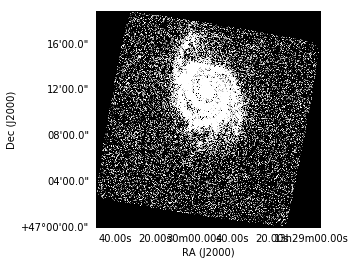

In [16]:
hdu_list=apfits.open('my_image3.fits')
gc = aplpy.FITSFigure(hdu_list,figsize=(4,4))
gc.show_grayscale(stretch='log', vmin=0.1,vmax=1.)
